<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/FastAIDRGrading_IIT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install fastai==1.0.42

In [ ]:
import os
 
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt
import cv2
 
from sklearn.model_selection import train_test_split
 
from PIL import Image
 
pd.set_option('display.max_colwidth',1000) # to avoid output truncation

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


#Train Data Read

In [ ]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"
 
df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['path'] = dataset_images_location + '/' + df['Image name'] + ".jpg"
df_['level'] = df['Retinopathy grade']
df = df_
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
#df['level'] = df['level'].astype('int32')
# df.head(10)
print(df)
 
img = cv2.imread(df['path'][1])
print(img.dtype)

                                                                                                  path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_055.jpg      3
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_079.jpg      1
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_163.jpg      0
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_307.jpg      0
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_117.jpg      2
..                                                                                                 ...    ...
408  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_214.jpg      0
409  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_093.jpg      2
410  /cont

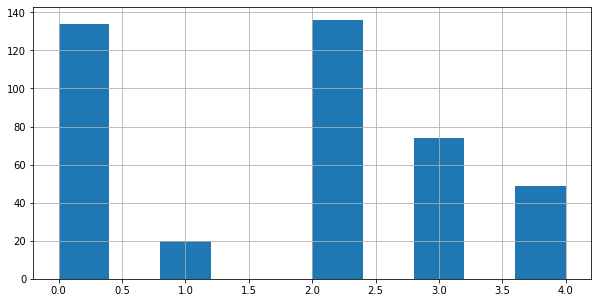

In [ ]:
df['level'].hist(figsize = (10, 5))

In [ ]:
df.pivot_table(index='level', aggfunc=len)

,path
level,
0,134
1,20
2,136
3,74
4,49


In [ ]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

In [ ]:
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

83

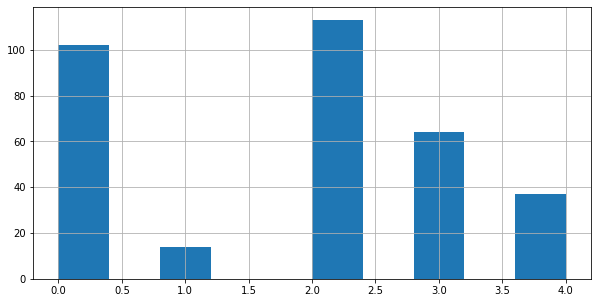

In [ ]:
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [ ]:
train_df.pivot_table(index='level', aggfunc=len)

,path
level,
0,102
1,14
2,113
3,64
4,37


New Data Size: 565 Old Size: 330


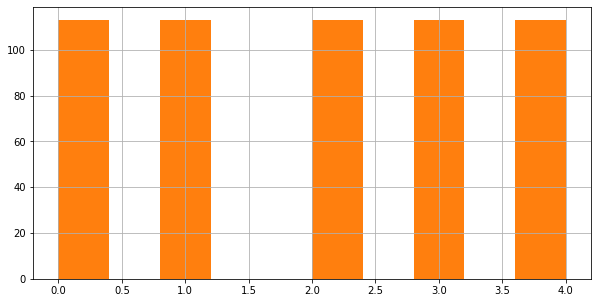

In [ ]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [ ]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)
print(df)

                                                                                                  path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_305.jpg      0
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_013.jpg      3
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_378.jpg      0
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_080.jpg      2
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_379.jpg      1
..                                                                                                 ...    ...
310  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_148.jpg      0
352  /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set/IDRiD_322.jpg      2
320  /cont

In [ ]:
im = Image.open(train_df['path'][1])
width, height = im.size
# im.show
# print(width,height)

In [ ]:
bs = 16 #smaller batch size is better for training, but may take longer
sz=224
print(len(train_df))
print(len(val_df))
print(len(df))

565
83
648


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
 
data = ImageDataBunch.from_df(path = '/', df = df, ds_tfms = tfms, size = sz, valid_pct = (len(val_df) / len(df)), bs = bs)
data = data.normalize(imagenet_stats)
print(data)

ImageDataBunch;

Train: LabelList (565 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,3,2,1,1
Path: /;

Valid: LabelList (83 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,4,2,3,3
Path: /;

Test: None


[0, 1, 2, 3, 4]


(5, 5)

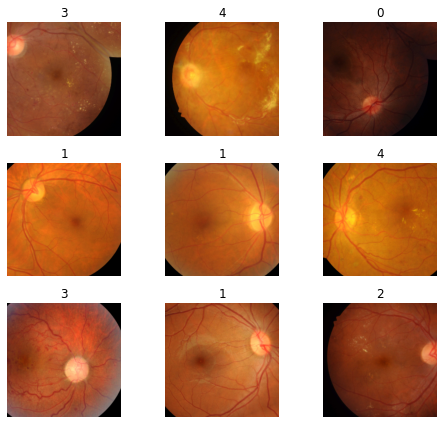

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

print(data.classes)
len(data.classes),data.c

#Transfer Learning

In [ ]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat.cpu(),1), y.cpu(), weights='quadratic'),device='cuda:0')

In [ ]:
import torchvision
learn = create_cnn(data, models.resnet50, metrics = [accuracy,quadratic_kappa])

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:109: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [ ]:
# learn.lr_find()

In [ ]:
# learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(4,max_lr = 1e-3)


epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.909645,1.470587,0.566265,0.720352,03:17
1,1.808684,1.137706,0.602410,0.779002,03:06
2,1.434571,1.017644,0.602410,0.780891,03:06
3,1.293735,0.924636,0.638554,0.856054,03:05


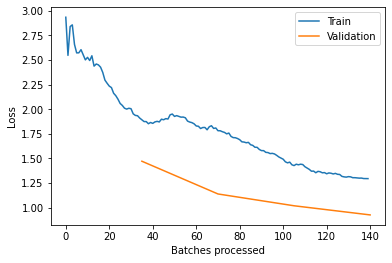

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1-224')
# see how to load the model

In [ ]:
learn.unfreeze()

In [ ]:
# learn.lr_find()

In [ ]:
# learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.097621,0.985383,0.650602,0.823392,03:05
1,1.027219,0.899212,0.698795,0.816619,03:07
2,0.972741,0.850912,0.698795,0.827183,03:06
3,0.932102,0.855163,0.710843,0.844906,03:07


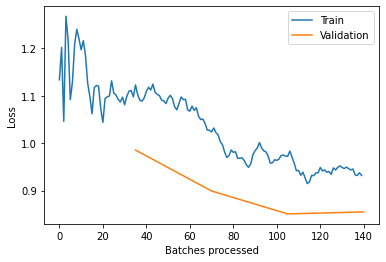

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-224')

#Progressive Resizing

In [ ]:
dataNew = ImageDataBunch.from_df(path = '/', df = df, ds_tfms = tfms, size = sz * 2, valid_pct = (len(val_df) / len(df)), bs = 4)
dataNew = dataNew.normalize(imagenet_stats)

In [ ]:
learn.data = dataNew
dataNew.train_ds[0][0].shape

torch.Size([3, 448, 448])

In [ ]:
learn.freeze()

In [ ]:
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4,max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.681147,1.103379,0.662651,0.743163,03:38
1,1.517698,0.787289,0.662651,0.711722,03:39
2,1.342944,0.878186,0.614458,0.649279,03:39
3,1.328175,0.951172,0.698795,0.706985,03:37


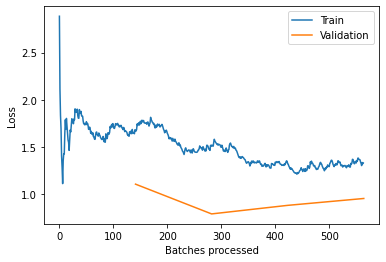

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1-448')

In [ ]:
learn.unfreeze()

In [ ]:
# learn.lr_find()
# learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa,time
0,1.205763,0.694489,0.734940,0.759157,03:40
1,1.320808,0.741857,0.710843,0.701640,03:40
2,1.270006,0.815993,0.734940,0.723384,03:40
3,1.102753,0.671593,0.722892,0.676684,03:42


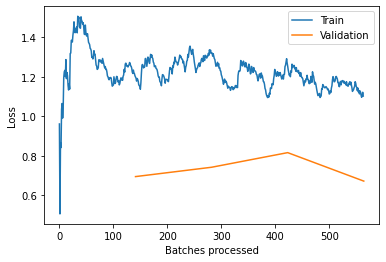

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-448')

#Checking Results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

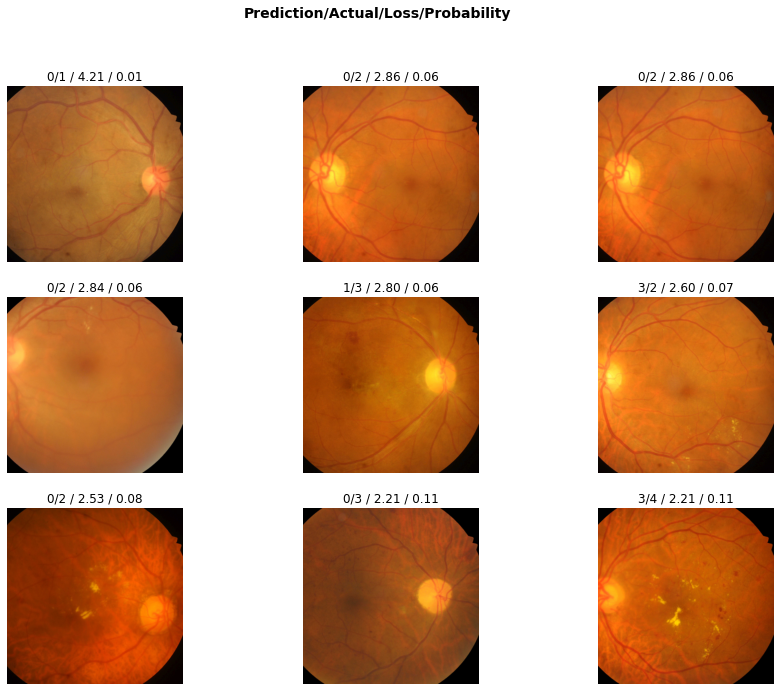

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

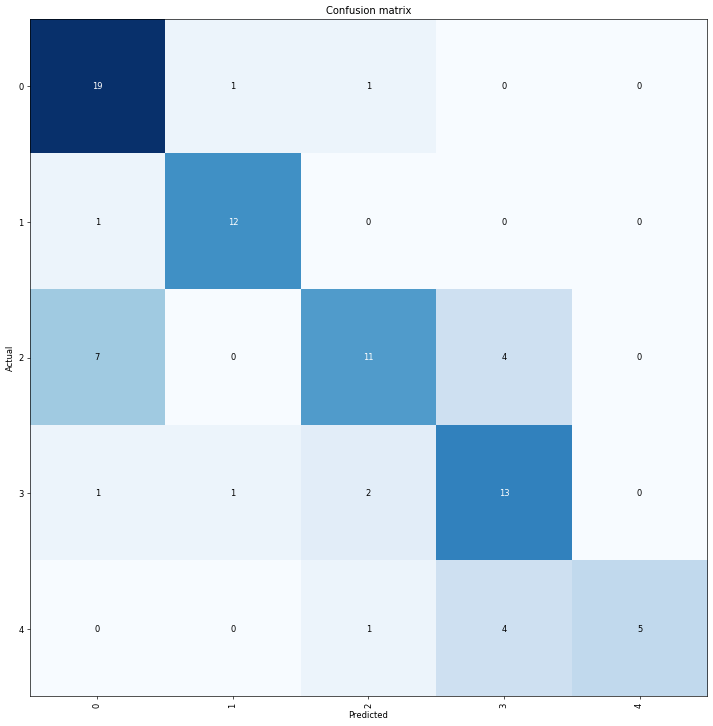

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Testing Data

In [ ]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['path'] = test_images_location + '/' + test_df['Image name'] + ".jpg"
test_df_['level'] = test_df['Retinopathy grade']
test_df = test_df_

print(test_df)

                                                                                                 path  level
0    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_001.jpg      4
1    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_002.jpg      4
2    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_003.jpg      4
3    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_004.jpg      4
4    /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_005.jpg      4
..                                                                                                ...    ...
98   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_099.jpg      0
99   /content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set/IDRiD_100.jpg      2
100  /content/drive

In [ ]:
# Create a test set to pass to our learner
test = (ImageList.from_df(path='/', df=test_df))
learn.data.add_test(test)

In [ ]:
# Get predictions
preds1, l1 = learn.get_preds(DatasetType.Test)
preds2, l2 = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
preds1

tensor([[2.1275e-01, 3.5101e-04, 1.6767e-02, 2.6204e-02, 7.4393e-01],
        [3.4926e-01, 5.8868e-02, 1.5012e-01, 3.9519e-01, 4.6559e-02],
        [4.9490e-01, 3.3251e-02, 3.5060e-01, 5.1640e-02, 6.9610e-02],
        [8.3178e-01, 3.5330e-02, 4.9315e-03, 3.0426e-02, 9.7534e-02],
        [1.6178e-01, 2.2373e-01, 1.2372e-02, 7.8763e-02, 5.2335e-01],
        [7.0851e-03, 5.4980e-03, 1.1880e-01, 7.0124e-01, 1.6738e-01],
        [1.9386e-02, 1.1044e-02, 2.4107e-01, 2.6387e-01, 4.6463e-01],
        [1.8895e-01, 3.8363e-02, 3.5055e-01, 3.7508e-01, 4.7059e-02],
        [1.0018e-03, 5.1550e-04, 6.6239e-01, 3.2813e-01, 7.9609e-03],
        [3.7803e-01, 6.5388e-03, 3.7574e-01, 2.2485e-01, 1.4847e-02],
        [3.7044e-02, 6.3337e-04, 7.9819e-01, 1.6219e-01, 1.9363e-03],
        [8.0410e-03, 9.6548e-01, 2.2577e-02, 3.8143e-03, 9.2236e-05],
        [6.8786e-05, 1.8539e-04, 2.7156e-03, 9.7466e-01, 2.2374e-02],
        [2.8663e-04, 2.9575e-03, 2.7522e-01, 6.6751e-01, 5.4031e-02],
        [1.6204e-03,

In [ ]:
preds2

tensor([[3.7097e-01, 6.1635e-04, 2.6389e-02, 3.0730e-02, 5.7130e-01],
        [2.4721e-01, 5.1225e-02, 3.2536e-01, 1.7546e-01, 2.0075e-01],
        [3.6321e-01, 7.1661e-02, 3.4409e-01, 2.4780e-02, 1.9626e-01],
        [5.3817e-01, 1.0480e-01, 1.0774e-02, 3.0435e-02, 3.1582e-01],
        [1.9225e-01, 1.8888e-01, 1.7803e-02, 3.7748e-02, 5.6332e-01],
        [2.5410e-02, 4.6758e-02, 9.7357e-02, 3.1372e-01, 5.1675e-01],
        [2.6672e-02, 3.6370e-02, 2.3965e-01, 1.5918e-01, 5.3812e-01],
        [1.0128e-01, 1.5414e-01, 2.6789e-01, 3.0250e-01, 1.7419e-01],
        [3.5966e-03, 1.0123e-02, 6.9237e-01, 2.5257e-01, 4.1339e-02],
        [2.0011e-01, 2.3517e-02, 5.4057e-01, 1.4420e-01, 9.1599e-02],
        [1.0622e-01, 5.2050e-03, 6.1184e-01, 2.2173e-01, 5.4998e-02],
        [9.3851e-02, 5.7923e-01, 2.1257e-01, 7.7050e-02, 3.7300e-02],
        [2.3215e-03, 3.7677e-02, 1.0298e-01, 5.9362e-01, 2.6341e-01],
        [6.6625e-03, 2.7074e-02, 3.9993e-01, 3.4016e-01, 2.2617e-01],
        [7.0749e-03,

In [ ]:
preds1 = np.array(preds1)
preds2 = np.array(preds2)
print("preds1", preds1.shape)
print("preds2", preds2.shape)

preds1 (103, 5)
preds2 (103, 5)


In [ ]:
preds1 = np.argmax(preds1, axis = 1)
preds2 = np.argmax(preds2, axis = 1)
print("preds1", preds1.shape)
print("preds2", preds2.shape)

preds1 (103,)
preds2 (103,)


In [ ]:
labels = test_df['level']
labels.shape

(103,)

In [ ]:
preds1

array([4, 3, 0, 0, ..., 2, 3, 2, 0])

In [ ]:
preds2

array([4, 2, 0, 0, ..., 2, 2, 2, 0])

In [ ]:
from sklearn.metrics import accuracy_score
print("preds1 => accuracy:", accuracy_score(labels, preds1))
print("preds2(with TTA) => accuracy:", accuracy_score(labels, preds2))

preds1 => accuracy: 0.5436893203883495
preds2(with TTA) => accuracy: 0.5339805825242718


In [ ]:
from sklearn.metrics import cohen_kappa_score
print("preds1 => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds1, weights = "quadratic"));
print("preds2(with TTA) => quadratic_weighted_kappa:", cohen_kappa_score(labels, preds2, weights = "quadratic"));

preds1 => quadratic_weighted_kappa: 0.6727653725693428
preds2(with TTA) => quadratic_weighted_kappa: 0.6776212832550861


preds1 => Confusion Matrix
[[26  6  2  0  0]
 [ 2  0  2  1  0]
 [ 6  3 12  9  2]
 [ 2  0  1 12  4]
 [ 3  0  0  4  6]]


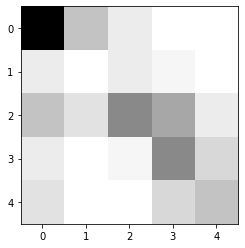

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(labels, preds1) 
print("preds1 => Confusion Matrix")
print(cm)
plt.imshow(cm, cmap = 'binary')

preds2(with TTA) => Confusion Matrix
[[21 11  2  0  0]
 [ 1  2  2  0  0]
 [ 5  2 15  6  4]
 [ 1  1  2  9  6]
 [ 2  1  2  0  8]]


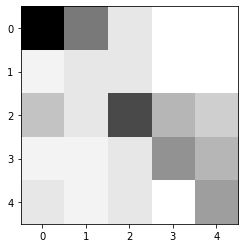

In [ ]:
cm = confusion_matrix(labels, preds2) 
print("preds2(with TTA) => Confusion Matrix")
print(cm)
plt.imshow(cm, cmap = 'binary')

In [ ]:
# TTA is easy - use .TTA() in place of .get_preds()
# preds_tta, labels_tta = learn.TTA(ds_type=DatasetType.Test)

In [ ]:
# acc_tta = accuracy(preds_tta, labels_tta)
# print(acc_tta)

In [ ]:
# test_images = []
# im_size = 224
# for image_path in df['path']:
#     img = cv2.imread(image_path)
#     img = cv2.resize(img, (im_size, im_size));
#     test_images.append(img);

In [ ]:
# test_pred = learn.predict_array(test_imgs)
# test_pred = np.argmax(test_pred, axis=1)
# test_pred